### An example of the SIGW inverse problem with the full numerical integration 

In [59]:
import sys
sys.path.append('../')
from jax import vmap, jit, grad, random, jacfwd
from jax.lax import map
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import warnings
from jax import config
config.update("jax_enable_x64", True)
import numpyro
from interpolation.omega_gw_jax import OmegaGWjax
from interpolation.model import Fixed_Nodes_Model, spline_predict
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=4,suppress=True)
jnp.set_printoptions(precision=4,suppress=True)
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


#### A simple test curvature power spectrum and $\Omega_{\rm GW}$

(40,)


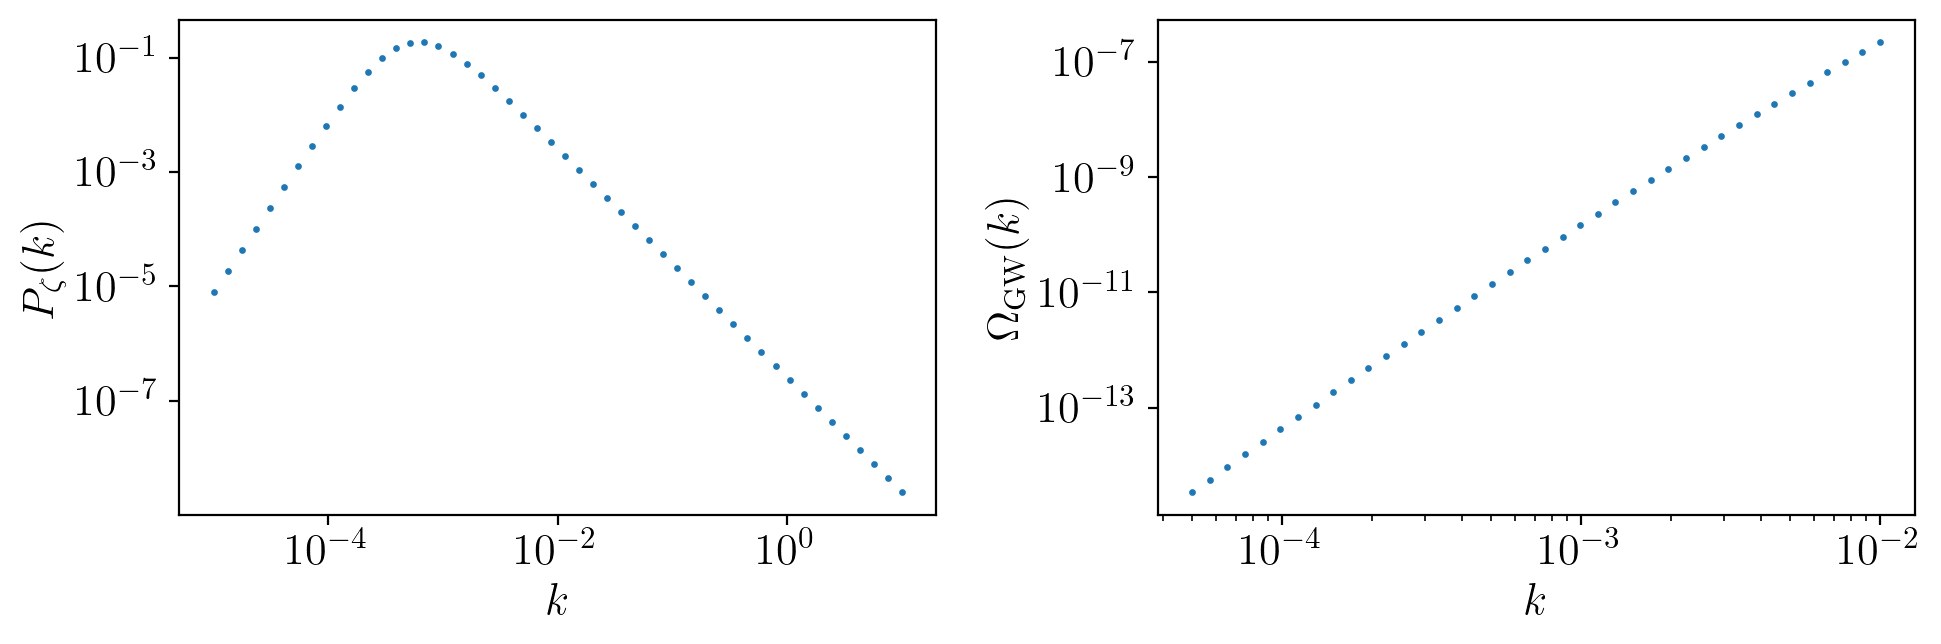

In [60]:
# set up the power spectrum and omgw
psize = 50
ksize = 40
k_arr = jnp.geomspace(5e-5,1e-2,ksize)
p_arr = jnp.geomspace(1e-5,1e1,psize)


f = k_arr #jnp.geomspace(5e-5, 1e-2, ksize)  # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1, 10)  # First rescaled internal momentum
t = jnp.logspace(-3,3, 100)  # Second rescaled internal momentum

## Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)

pstar=5e-4
n1=3
n2=-2
sigma=2

@jit
def pz(p,kmax,etaR):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    # osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    return pl1 * pl2 #*osc

gwb_calculator =  OmegaGWjax(s, t, f=f, kernel="I_MD_to_RD", upsample=False,norm="CT")

kmax = 1e-2
etaR = 1./kmax
transition_params = [kmax,etaR]

pz_amp = pz(p_arr,*transition_params)
gwb_amp = gwb_calculator(pz,f,*transition_params)

print(gwb_amp.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.scatter(p_arr,pz_amp,s=2)
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.scatter(f,gwb_amp,s=2)
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout();

#### Let's set up the inference with an uncertainity on the GWB

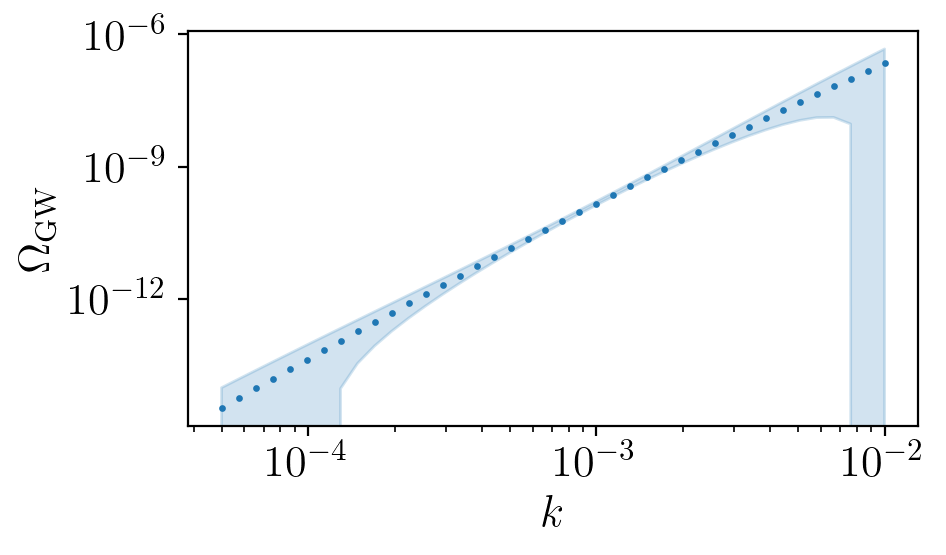

In [61]:
kstar = 1e-3
omks_sigma = gwb_amp*( 0.1*(np.log(k_arr/kstar))**2 + 0.05) # 2% error at kstar + more towards edges
gwb_cov = jnp.diag(omks_sigma**2)
fig,ax = plt.subplots(1,1,figsize=(5,3.))
ax.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
ax.scatter(k_arr,gwb_amp,s=2)
ax.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout()

In [62]:
# Set up the fixed node interpolator
kmin, kmax = min(p_arr), max(p_arr)
n=6
gwb_method_kwargs = {'s': s, 't': t, 'kernel' : "I_MD_to_RD", 'upsample': False, 'norm': "CT"}
pz_model = Fixed_Nodes_Model(n_nodes=n,pz_kmin=kmin,pz_kmax=kmax,
                            gwb_karr=k_arr,gwb_means=gwb_amp,
                            gwb_cov=gwb_cov,gwb_method='jax',
                            gwb_method_kwargs=gwb_method_kwargs,y_low=-5,y_high=0, gwb_args_bounds=[-3,-1])

-3 -1


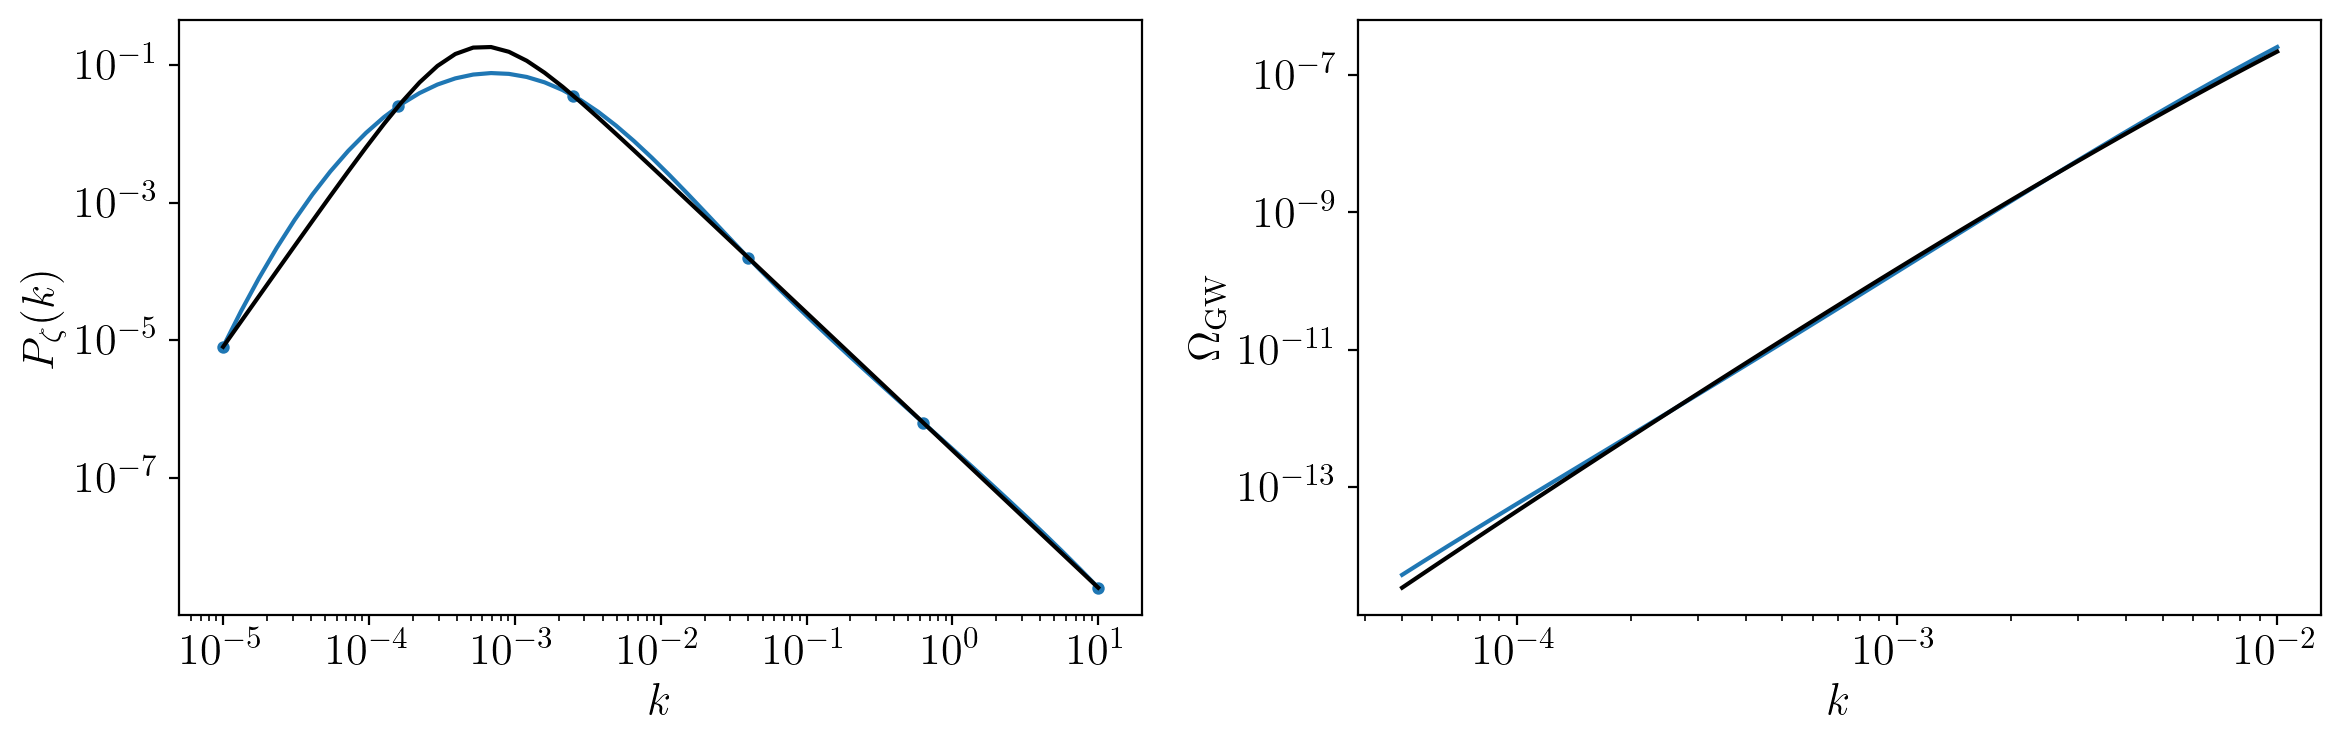

In [63]:
# for smaller pz_kmax the reconstruction is not as good since the contribution of the UV modes is not well captured

ps = jnp.geomspace(min(p_arr),max(p_arr),n)
ys = pz(ps,*transition_params)
fig,ax = plt.subplots(1,2,figsize=(12,4.))

pz_interp_amps = pz_model.spline(x=jnp.log10(ps),y=jnp.log10(ys),k=p_arr)
omgw_amps = pz_model.get_gwb_from_xy(x=jnp.log10(ps),y=jnp.log10(ys),extra_args=transition_params)

ax[0].scatter(ps,ys,s=12)
ax[0].plot(p_arr,pz_interp_amps)
ax[0].plot(p_arr,pz_amp,color='k')
ax[1].plot(k_arr,omgw_amps)
ax[1].plot(k_arr,gwb_amp,color='k')
for x in ax:
    x.set(xscale='log',yscale='log',xlabel=r'$k$')
ax[0].set_ylabel(r'$P_{\zeta}(k)$')
ax[1].set_ylabel(r'$\Omega_{\mathrm{GW}}$')
fig.tight_layout()


In [64]:
# run the HMC
samples, extras = pz_model.run_hmc_inference(num_warmup=512,num_samples=512,seed=4)

warmup:   3%|▎         | 31/1024 [00:04<02:30,  6.58it/s, 63 steps of size 2.55e-03. acc. prob=0.70]


KeyboardInterrupt: 

#### Now we plot some realisations of the inferred $P_{\zeta}$ from the MCMC samples

(16, 50)


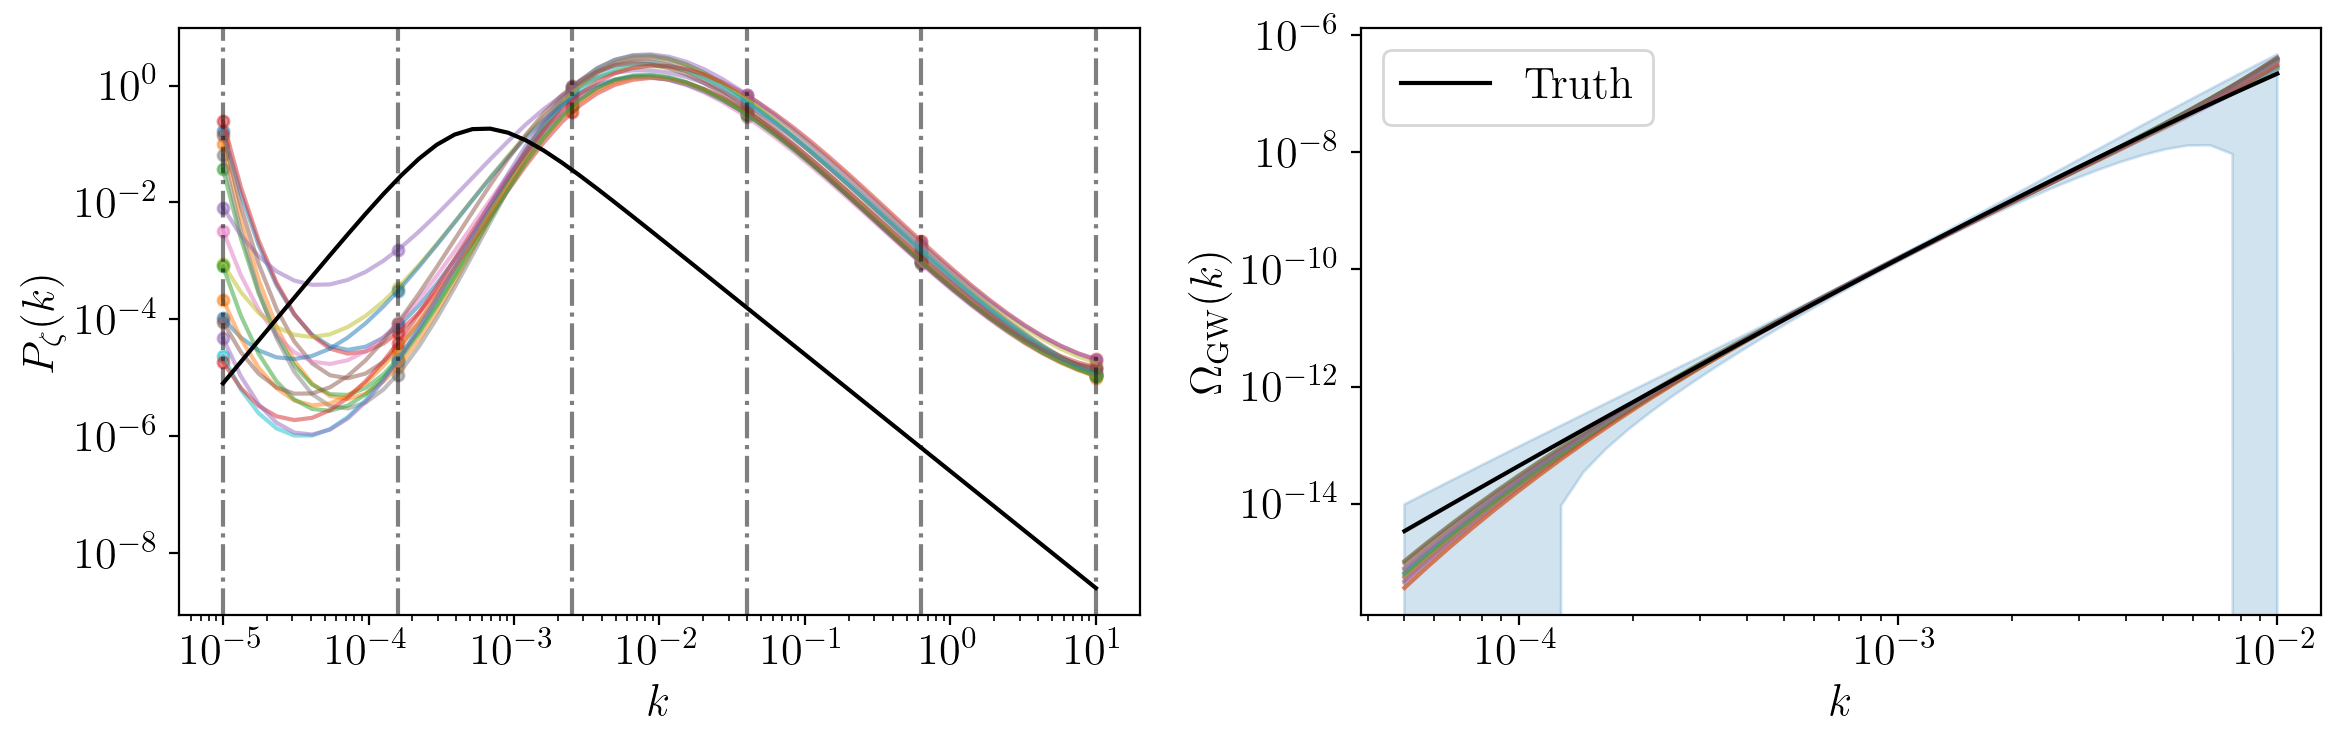

In [ ]:
thin_factor = 32
nodes = pz_model.log_k_nodes
ys = samples['y'][::thin_factor] 
kmaxs = samples['kmax'][::thin_factor] 
etaRs = samples['etaR'][::thin_factor] 
def omega_f(y,kmax,etaR):
    res = pz_model.get_gwb_from_xy(x=nodes,y=y,extra_args=jnp.array([kmax,etaR]))
    return res
gwb_amps = vmap(omega_f,)(ys,kmaxs,etaRs)

ff = lambda y: pz_model.spline(x=nodes,y=y,k=p_arr)
pz_amps = vmap(ff,)(ys)
print(pz_amps.shape)
# gwb_amps = jnp.einsum("pi,pj,kij->pk",pz_amps,pz_amps,gwb_calculator.omkij)
# print(gwb_amps.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

for i,pzs in enumerate(pz_amps):
    ax1.loglog(p_arr,pzs,alpha=0.5)
    ax1.scatter(10**(nodes),10**(ys[i]),s=16,alpha=0.5)
for om in gwb_amps:
    ax2.loglog(k_arr,om,alpha=0.5)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,gwb_amp,color='k',lw=1.5,label='Truth')
ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
# ax2.set_ylim(1e-5,1.)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
for val in nodes:
    ax1.axvline(10**(val),color='k',ls='-.',alpha=0.5)
fig.tight_layout()

# the dashed lines represent the spline node locations

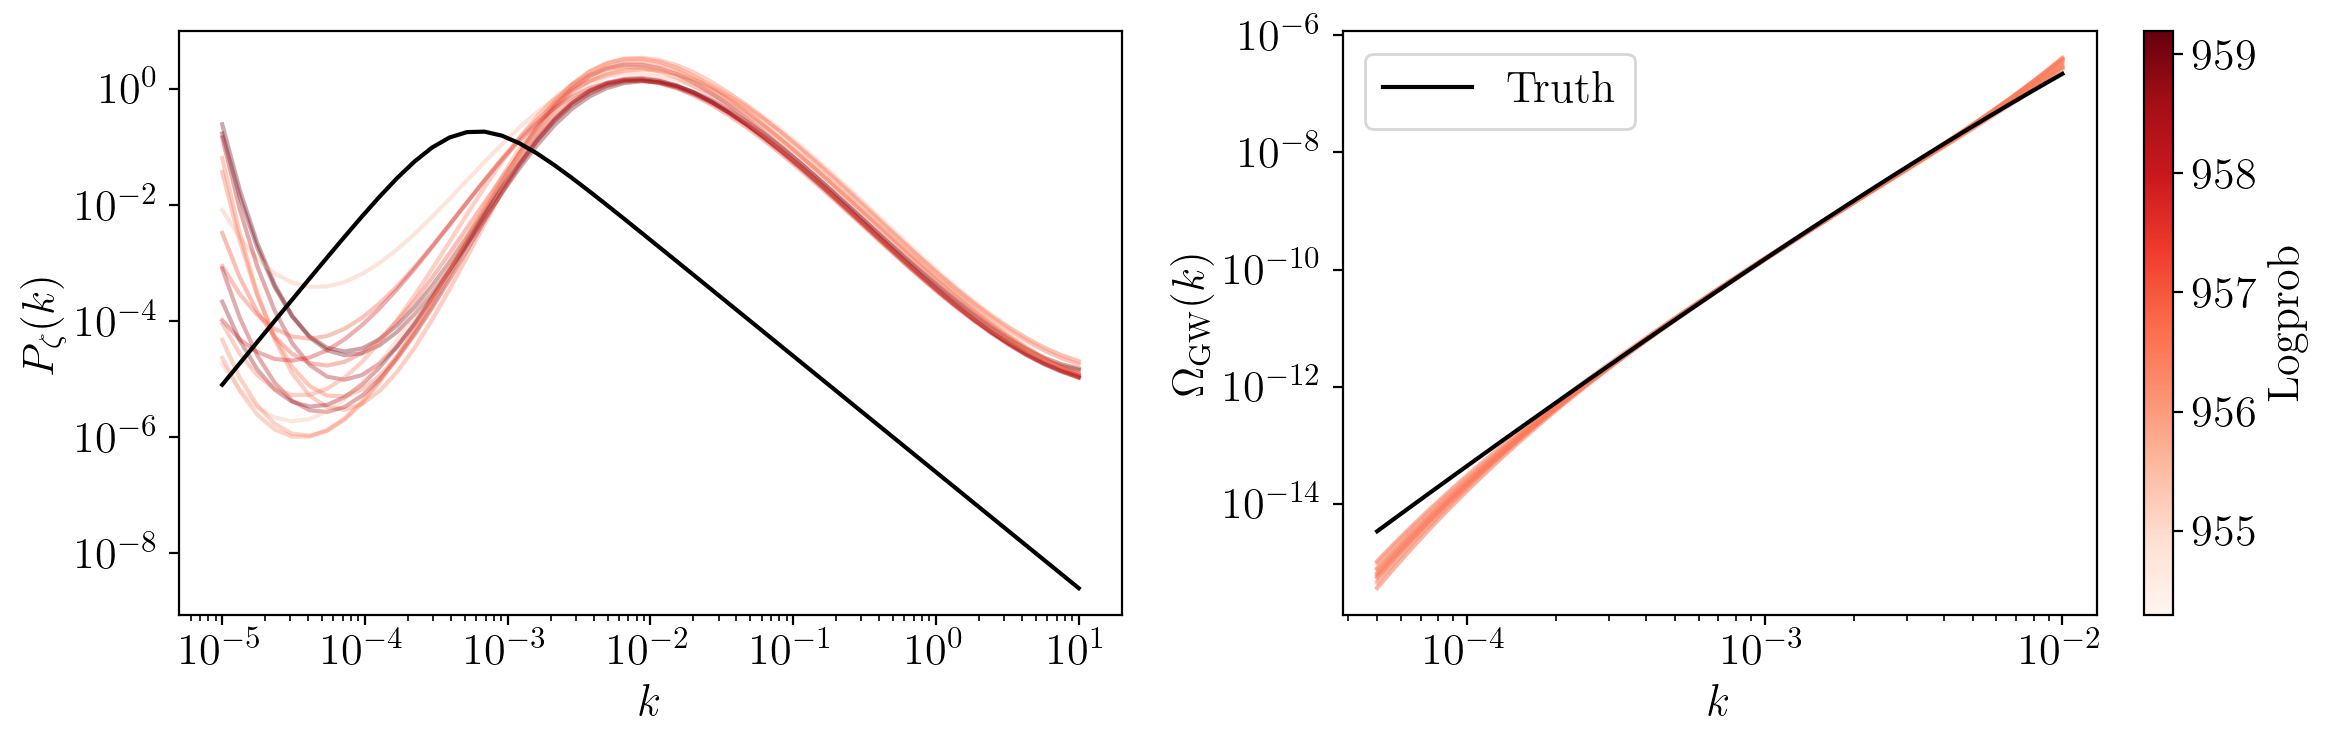

In [ ]:
### Plot the MC realisations with their logprob
cmap = matplotlib.colormaps['Reds']
ys = samples['y']
lp = -extras["potential_energy"][::thin_factor] # PE = -negative logprob
lp_min, lp_max = np.min(lp), np.max(lp)
cols = (lp-lp_min)/(lp_max - lp_min) # normalise the logprob to a colour
norm = colors.Normalize(lp_min,lp_max)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
# pz_amps = vmap(ff,)(ys)
for i,pz in enumerate(pz_amps):
    ax1.loglog(p_arr,pz,alpha=0.35,color=cmap(cols[i]))
    # ax1.scatter(10**(nodes),10**(ys[i]),s=16,alpha=0.5)
for om in gwb_amps:
    ax2.loglog(k_arr,om,alpha=0.35,color=cmap(cols[i]))
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.loglog(k_arr,gwb_amp,color='k',lw=1.5,label='Truth')

ax2.legend()
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
# ax2.set_ylim(1e-5,1.)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=ax2,label='Logprob')
fig.tight_layout()

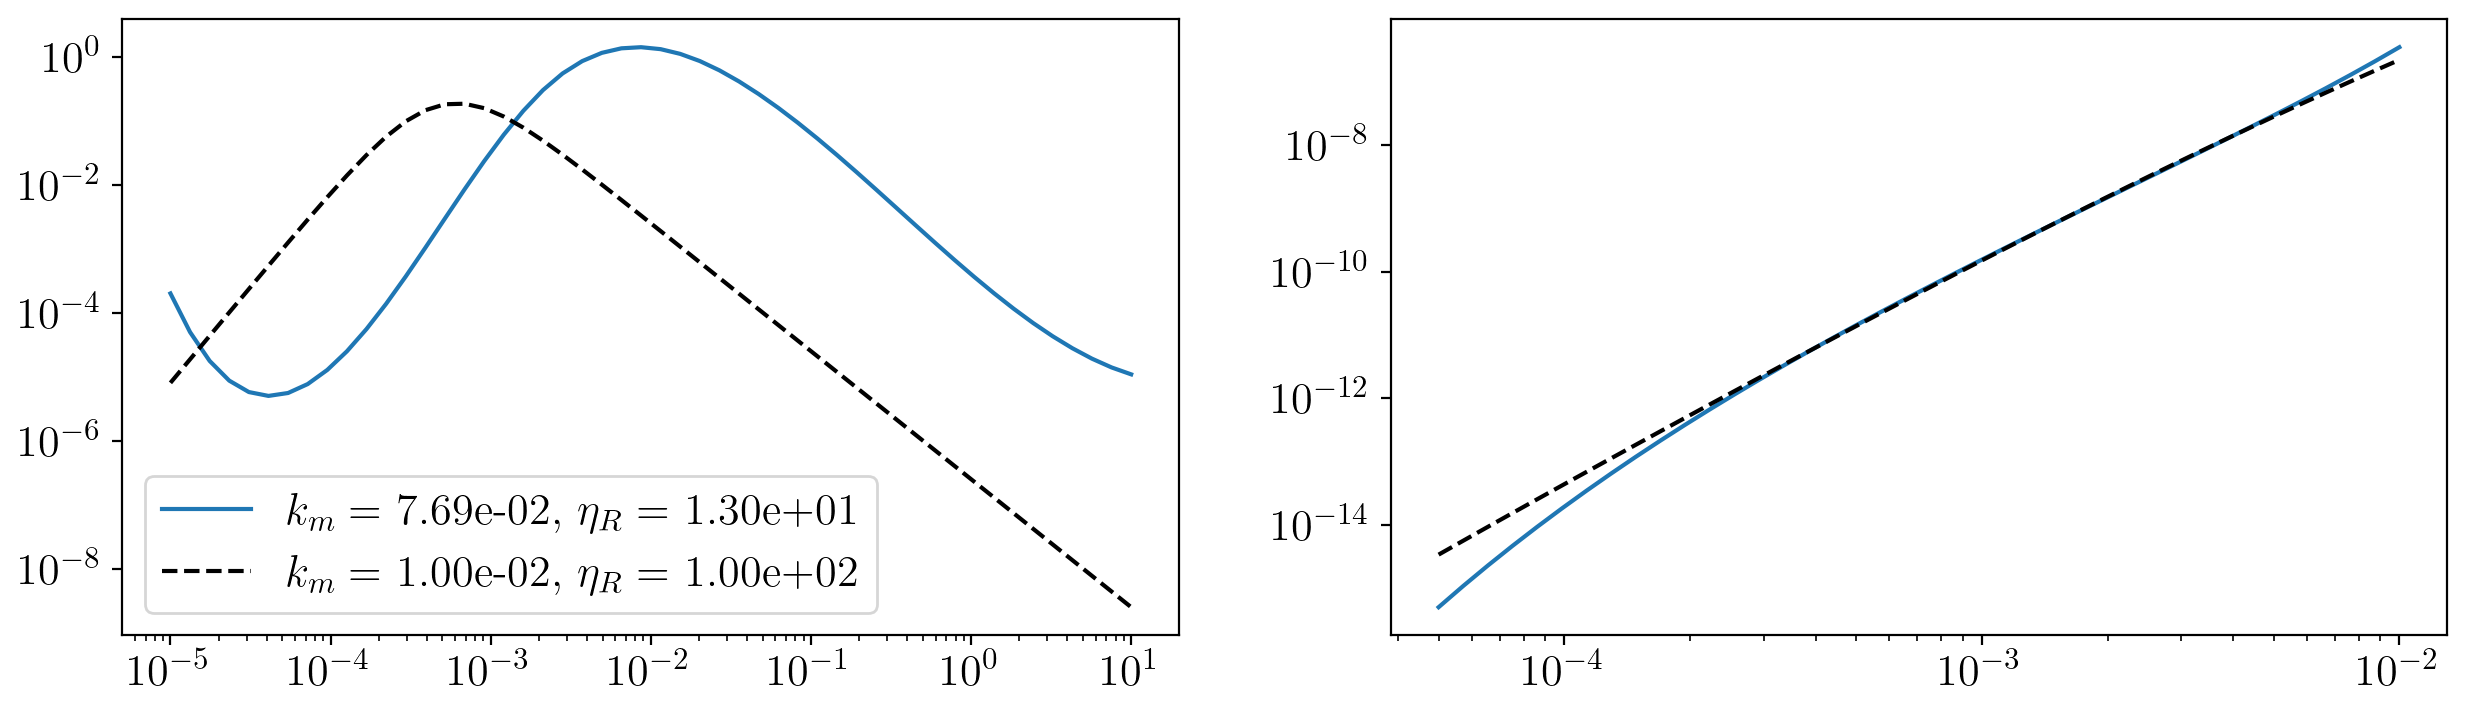

In [58]:
idx = np.random.randint(0,len(ys))
ys, kmax, etar = samples['y'][idx], samples['kmax'][idx], samples['etaR'][idx]
pz_interp = lambda k, kmax, etaR: pz_model.spline(x=nodes,y=ys,k=k)
omgw_test = gwb_calculator(pz_interp,k_arr,kmax,etar)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
ax1.plot(p_arr,pz_interp(p_arr,kmax,etar),label=r'$k_m = $ {:.2e}, $\eta_R = $ {:.2e}'.format(kmax,etar))
kmax = 1e-2
etaR = 1./kmax
ax1.plot(p_arr,pz_amp,label=r'$k_m = $ {:.2e}, $\eta_R = $ {:.2e}'.format(kmax,etaR),color='k',ls='--')
ax2.plot(k_arr,omgw_test)
ax2.plot(k_arr,gwb_amp,color='k',ls='--')
for x in [ax1,ax2]:
    x.set(xscale='log',yscale='log')
ax1.legend()

#### Do an optimization instead of HMC sampling

In [25]:
# from interpolation.model import optim_scipy_bh , optim_optax
# nodes = pz_model.log_k_nodes
# best_idx = jnp.argmin(extras['potential_energy'])
# worst_idx = jnp.argmax(extras['potential_energy'])
# print(samples['y'][worst_idx])
# x0 = samples['y'][best_idx]  
# print(x0)
# # x0 = -1.5*jnp.ones(5)
# best_params, _ = optim_scipy_bh(x0 = x0,loss = pz_model.loss,bounds=len(x0)*[(-7,1)],stepsize=0.2,niter=20) 
# # best_params, _ =  optim_optax(x0 = -1.5*jnp.ones(5), loss = pz_model.loss, start_learning_rate=0.3 , steps = 200, jump_sdev=1.,y_low=-8.,y_high=-0.)
# print(best_params)
# pz_bf = lambda x: spline_predict(x_train=nodes,y_train=best_params,x_pred=x)
# # gwb_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)
# gwb_bf = pz_model.get_gwb_from_xy(x=nodes,y=best_params) #gwb_calculator(pz_bf,f) #jnp.einsum("i,j,kij->k",pz_bf,pz_bf,gwb_calculator.omkij)

In [26]:
# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

# ax1.loglog(p_arr,pz_bf(p_arr),color='r')
# ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
# ax2.plot(k_arr,gwb_amp,color='k',lw=1.5,label='Truth')
# ax2.loglog(k_arr,gwb_bf,color='r',label='reconstructed')
# ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='C0')
# ax2.set(yscale='log',xscale='log')

# ax1.set_ylabel(r'$P_{\zeta}(k)$')
# ax1.set_xlabel(r'$k$')
# ax1.set_ylim(1e-5,1.)
# ax2.set_ylim(1e-4,1.)

# ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
# ax2.set_xlabel(r'$k$')
# ax2.legend()
# for val in nodes:
#     ax1.axvline(10**(val),color='k',ls='-.',alpha=0.5)
# ax1.scatter(10**(nodes),10**(best_params),color='r')
# fig.tight_layout()
